# undistort
ピンホールカメラモデルをベースとしてカメラキャリブレーション(歪み補正)を行うNotebookです。Jetson Nano Mouseに搭載されたステレオカメラは歪みが生じているため、まっすぐなものが曲がって撮影されます。このNotebookではカメラの歪み具合を推定し、ゆがんだ画像を歪みのない画像に変換します。また歪み具合をファイルに書き出し別のプログラムで使用できるようにします。

ピンホールカメラモデルをベースとしたカメラキャリブレーションは原理が単純ですが比較的小さな歪みを補正するためのものです。今回使用するカメラは歪みが大きいため、魚眼カメラモデルを用いたほうがより広い範囲をキャリブレーションできます。こちらのNotebookはピンホールカメラモデルと魚眼カメラモデルの違いを実感するための参考にご利用ください。魚眼カメラモデルを用いたカメラキャリブレーションは`undistort/undistort_fisheye.ipynb`で行います。

## キャリブレーション手順
1. 事前に`undistort/undistort_data_collection.ipynb`を実行してキャリブレーション用画像を撮影します
1. `undistort/chess_images`ディレクトリに撮影したキャリブレーション画像があることを確認します
1. セルを順に実行し歪み補正された画像が作成されれば正常にキャリブレーションが完了しています

## カメラキャリブレーションの効果と必要性
現実のカメラで撮影した画像にはレンズによる歪みが発生し、画像処理の大敵となります。歪みによって撮影した物体が現実と異なる形状としてカメラに写ることで、ロボットが物体の形状や位置関係を正しく認識できなくなるからです。そこで画像処理を行う前にカメラのキャリブレーションによる歪み補正が必要になります。

<details><summary><h4> ✍ 歪み補正に用いるカメラモデルについて詳しくはこちらをクリックして解説をご覧ください</h4></summary><div>

歪みは画像中心から離れれば離れるほど大きくなり、歪みの形状は樽型と糸巻き型の2つが存在します。

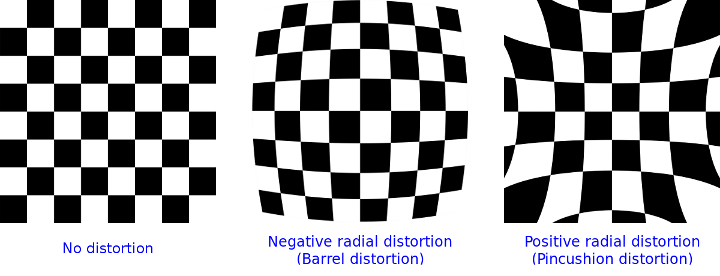

* 画像引用元
    * [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d%5D%EF%BC%89)

この歪みは以下の数式でモデル化されています。
\begin{equation}
\begin{bmatrix}
x_d\\
y_d\\
\end{bmatrix} =
\begin{bmatrix}
x \frac{1 + k_1r^2 + k_2r^4 + k_3r^6}{1+k_4r^2+k_5r^4+k_6r^6} + 2p_1xy + p_2(r^2+2x^2) + s_1r^2 + s_2r^4\\
y \frac{1 + k_1r^2 + k_2r^4 + k_3r^6}{1+k_4r^2+k_5r^4+k_6r^6} + p_1(r^2+2y^2) + 2p_2xy + s_3r^2 + s_4r^4\\
\end{bmatrix} \tag{1}
\end{equation}

$(x_d, y_d)$は歪み後の画像位置、$(x, y)$は歪みの無い場合の画像位置、$r$は画像中心から$(x, y)$までの距離、$(k_1, k_2, k_3, k_4, k_5, k_6, p_1, p_2, s_1, s_2, s_3, s_4)$はカメラ歪みを表す係数を指します。
式(1)を簡略化すると以下の式となります。

$$
\begin{bmatrix}
x_d\\
y_d\\
\end{bmatrix} =
\begin{bmatrix}
x(1+k_1r^2+k_2r^4) + 2p_1xy + p_2(r^2+2x^2)\\
y(1+k_1r^2+k_2r^4) + p_1(r^2 + 2y^2) + 2p_2xy\\
\end{bmatrix} \tag{2}
$$

式(2)が今回の歪み補正で使用する歪みモデルとなります。

### 歪み係数の取得について
歪みの計測には既知形状の物体を使用します。今回のプログラムではキャリブレーションボードと呼ばれる、平面にチェス盤状の白黒の格子模様が書かれたボード(以下チェスボード)を用いることにします。   
チェスボードを用いたカメラキャリブレーションではボードが平面である事、格子点が等間隔でその長さが分かっている事を利用して歪み係数を含むカメラパラメータを推定します。また、チェスボードは格子点が特徴として見つけやすいため、サブピクセル単位での再計算による正確なカメラパラメータの推定が可能となります。

* 参考: 
    * [カメラキャリブレーション — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_calib3d/py_calibration/py_calibration.html)

</div></details>

## カメラキャリブレーション
下記に続くセルを順に実行していきます。まずは必要なPythonモジュールを読み込みます。

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
np.set_printoptions(threshold=5)

キャリブレーションを行うカメラを指定します。右カメラをキャリブレーションする際は`camera_position`に文字列`right`を代入してください。左カメラの場合は`left`を代入します。セルを実行するとキャリブレーション用画像のファイルパスが一覧になって表示されることをご確認ください。

In [2]:
camera_position  = "left"

if camera_position == "left":
    imgs_dir = sorted(glob.glob(os.path.join('chess_images', '*left*.jpg')))
elif camera_position == "right":
    imgs_dir = sorted(glob.glob(os.path.join('chess_images', '*right*.jpg')))
else:
    print("camera_positionの入力が間違っています．")
print(imgs_dir)

['chess_images/326b47e2-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/3b0da6d8-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/427dad0a-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/4554d9f4-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/47d3933c-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/4a22d03a-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/4e3a0d00-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/4fd662d0-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/6e016e94-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/75c66224-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/7bed500e-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/829f2b8e-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/84d572b4-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/8670ed42-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/883ebe06-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images/900899ea-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_

チェスボードの角(格子点)の数とマスの辺の長さを`camera_config.xml`から読み込みます。

In [3]:
tree = ET.parse("../camera_param/camera_config.xml")
root = tree.getroot()
v_num = int(root.find("board_param").find("v_num").text) # 横方向の格子点数
h_num = int(root.find("board_param").find("h_num").text) # 縦方向の格子点数
chess_size = float(root.find("board_param").find("chess_size").text) # チェスボード１マスあたりの長さ[mm]

キャリブレーションに必要なobject pointsを作成します。object pointsはワールド座標系におけるチェスボードの格子点の位置です。今回は歪み補正のみ行うためobject pointsの大きさは正規化されています。撮影対象の奥行きを計測する`undistort/undistort_stereo.ipynb`では現実の距離が必要になるのでobject pointsにチェスボードのマスの大きさが反映されています。

In [4]:
object_point = np.zeros((v_num*h_num, 3), np.float32)
object_point[:,:2] = np.mgrid[0:v_num, 0:h_num].T.reshape(-1,2)

object_points = [] # 上述したobject_pointの集まり（3次元ベクトルのリスト）
img_points = [] # 画像座標上での格子点（2次元空間）の集まり（2次元ベクトルのリスト）

各キャリブレーション用画像からチェスボードの格子点を検出し、`img_points`に保存します。`img_points`の位置関係からカメラの歪み具合が推定できます。`img_points`が二次元画像上の格子点の位置を保存し、`object_points`が三次元空間上の格子点の位置を保存しています。

In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # 反復アルゴリズムの終了基準の指定
imgs = [] # 画像表示用

for img_dir in imgs_dir:
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    ret, corners = \
        cv2.findChessboardCorners(
            img,
            (v_num, h_num),
            None) # 画像から格子点を探す（ピクセル単位）
    if ret == True: # 検出に成功した画像のみ検出結果を保存する
        object_points.append(object_point)
        corners_subpix = cv2.cornerSubPix(img, corners, (11, 11), (-1, -1), criteria) # サブピクセル単位で画像座標上での格子点を再計算
        img_points.append(corners_subpix)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = cv2.drawChessboardCorners(img, (v_num,h_num), corners_subpix, ret) # 検出した格子点の描画
        imgs.append(img)

チェスボードの格子点が正しく検出されているか確認するため、検出結果を表示する関数を作成します。

In [6]:
def gridShow(imgs):
    img_num = len(imgs)
    col = 3
    row = np.ceil(img_num / col)
    fig = plt.figure(figsize=(18, 4*row))
    for i, img in enumerate(imgs):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis = fig.add_subplot(row, col, i + 1)
        axis.imshow(img)
        i = i + 1

チェスボードの格子点の検出結果を表示します。格子点が色のついた線で結ばれていれば正常に検出されています。

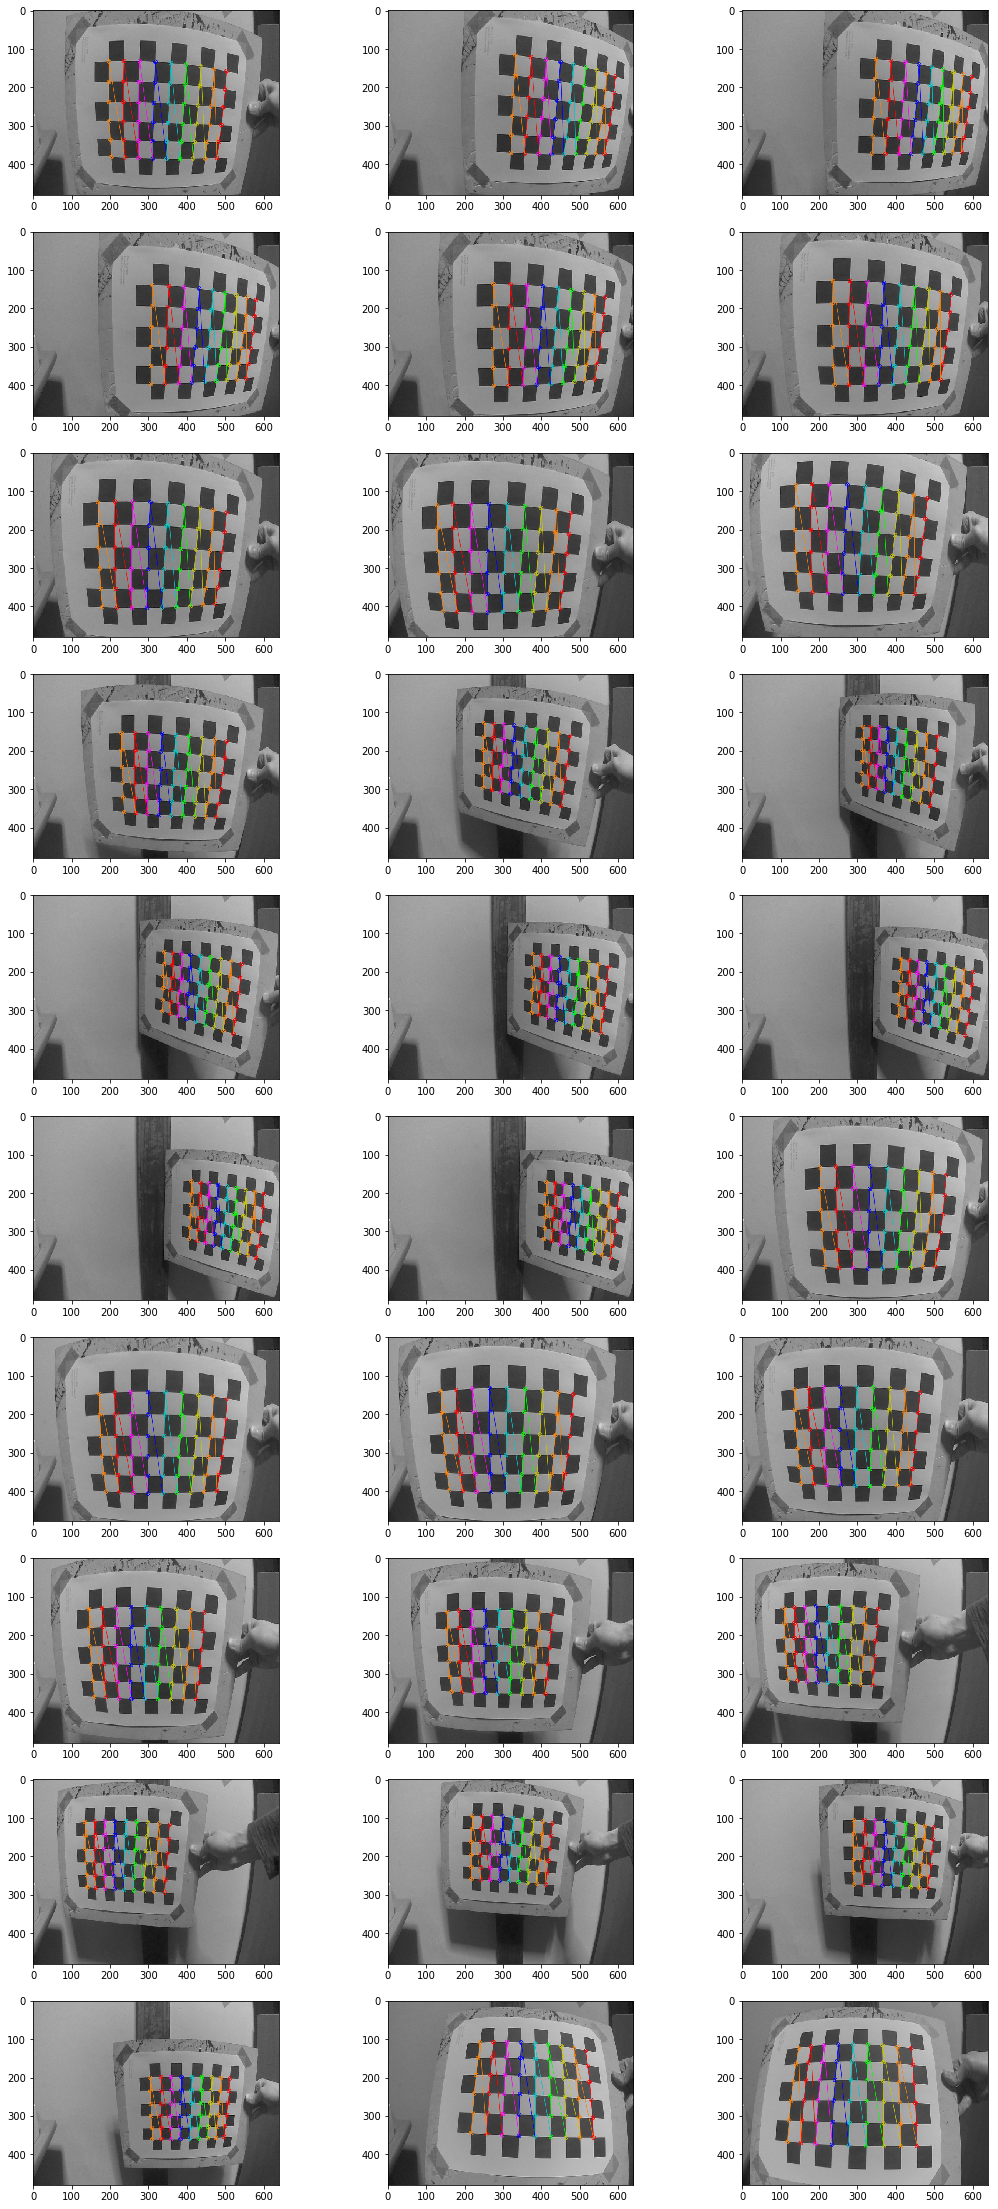

In [7]:
gridShow(imgs)

キャリブレーション用画像からカメラモデルを推定します。このカメラモデルにカメラの歪み具合などの情報が含まれており、歪み補正に使用します。
* カメラモデルのパラメータ
    * `rms`: 再投影誤差(root mean square)
    * `mtx`: カメラの内部パラメータ行列
    * `dist`: 歪み係数のベクトル(ここではk_1, k_2, p_1, p_2)
    * `rvecs`: 各視点における回転ベクトル（ロドリゲス形式）
    * `tvecs`: 各視点における並進ベクトル（x, y ,z）

<details><summary> <h4>✍ キャリブレーションについて詳しくはこちらをクリックして解説をご覧ください</h4></summary><div>
見つけ出した格子点の情報からカメラキャリブレーションを行います。キャリブレーションではカメラの内部パラメータ、外部パラメータ、歪み係数の推定が行われます。   

内部パラメータとは
\begin{equation}
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0  & 0 & 1
\end{bmatrix}
\end{equation}
で表されるカメラ座標系上の三次元点を画像座標系上の二次元点に投影するための行列です。$f_x$、$f_y$は$x$方向、$y$方向の焦点距離(物理的な焦点距離[mm]に受光素子の大きさ[pixel/mm]の積)、$c_x$，$c_y$は光軸の画像上での位置を意味します。

外部パラメータはワールド座標系上の点をカメラ座標系に座標変換するための回転行列と並進行列になります。

この2つのパラメータによって実空間上の三次元点を同次座標で表すと   

\begin{equation}
\begin{bmatrix}
u \\
v \\
w
\end{bmatrix}
=
\begin{bmatrix}
f_x & 0 & c_x & 0\\
0 & f_y & c_y & 0\\
0  & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
R_x & 0 & 0 & T_x \\
0 & R_y & 0 & T_y \\
0 & 0 & R_z & T_z \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
\end{equation}

で透視投影されることになります。   
(補足: OpenCVでは回転行列をロドリゲス形式で表すため、返り値は$R_x$, $R_y$、$R_z$を含む3x3の回転行列ではなく、$r_x$、$r_y$、$r_z$で表される3x1の回転行列です。
[OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac)を参照して下さい。）

またcv2.calibrateCamera()では推定したパラメータを用いた再投影誤差の計算も行います。再投影誤差とは推定した内部パラメータと外部パラメータから、予め与えたワールド座標系の三次元点(object_points)を画像座標系に投影した二次元点と実際の画像座標系の二次元点(img_points)の誤差を意味しています。つまり上記の式の計算結果とimg_pointsの差となります。   
これが小さいほどカメラパラメータの推定が上手くいっていると言えますが、得られる誤差の単位はpixelのため、画像の解像度や画像内のチェスボードのサイズ等に影響されます。そのためどの程度小さければ良いかという目安はありませんが、640 x 480の画像で画面に大きくチェスボードを映した場合、3以上の誤差があれば明らかにキャリブレーションに失敗していると言っていいでしょう。

</div></details>


In [8]:
h, w = img.shape[:2]

rms, mtx, dist, rvecs, tvecs = \
    cv2.calibrateCamera(
        object_points,
        img_points,
        (w, h),
        None,
        None
    )

推定した歪み具合から逆算し、歪みを補正したカメラモデルを作ります。

In [9]:
newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [10]:
print("再投影誤差: \n{}\n".format(rms))
print("内部パラメータ: \n{}\n".format(mtx))
print("歪みパラメータ: \n{}\n".format(dist))

再投影誤差: 
0.313901792585819

内部パラメータ: 
[[394.34648767   0.         335.23395939]
 [  0.         525.52823267 304.57579305]
 [  0.           0.           1.        ]]

歪みパラメータ: 
[[-3.63027584e-01  2.03059032e-01  9.47319508e-05  1.99055024e-05
  -7.76718882e-02]]



補正前、補正後のカメラモデルを用いて画像の歪み補正を行います。左上が補正前、右上が補正後です。使用しているカメラが広角で歪みが大きいため、画像の変形も大きくなっています。周辺の歪みが大きい部分を切り抜いた画像が右下です。チェスボードのマス目がまっすぐになっていれば正常に歪み補正がされています。このよう使う領域だけ画像を切り抜いた際、切り抜いた領域のことを対象領域(ROI: Region of Interest)などとよびます。

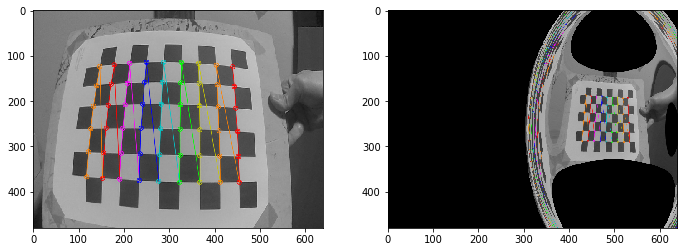

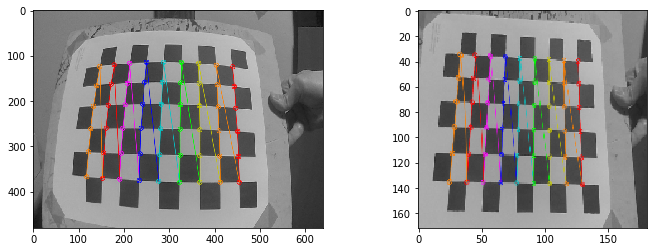

In [11]:
undistorted_img = cv2.undistort(img, mtx, dist, None, newmtx)
x, y, w, h = roi
undistorted_roi_img = undistorted_img[y:y+h, x:x+w]

gridShow([img, undistorted_img])
gridShow([img, undistorted_roi_img])

作成したカメラモデルを保存します。保存したカメラモデルはステレオカメラキャリブレーションの際に初期値として使用されます。

In [12]:
if camera_position == "left":
    np.savez('../camera_param/camera_param_l.npz',
            mtx_l=mtx,
            dist_l=dist
            )
else:
    np.savez('../camera_param/camera_param_r.npz',
        mtx_r=mtx,
        dist_r=dist
        )

## まとめ
ピンホールカメラモデルをベースとしてカメラキャリブレーションを行い、画像の歪み補正をしました。次のステップの`undistort_stereo.ipynb`では保存したカメラモデルを用いてカメラと撮影対象の距離を推定します。